In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.models import Model


In [43]:
n = 4
i1 = n - 1
i2 = n + 29
i3 = n + 59

In [44]:
data_dir = '101food/train'

classes = sorted(os.listdir(data_dir))
selected_classes = [classes[i1], classes[i2], classes[i3]]
selected_classes

['beef_carpaccio', 'edamame', 'macarons']

In [45]:
train_data = []
test_data = []

for cls in selected_classes:
    cls_path = os.path.join(data_dir, cls)
    cls_images = [os.path.join(cls, img) for img in os.listdir(cls_path)]
    train, test = train_test_split(cls_images, test_size=0.3, random_state=42)
    train_data.extend([(cls, img) for img in train])
    test_data.extend([(cls, img) for img in test])

train_df = pd.DataFrame(train_data, columns=['class', 'image'])
test_df = pd.DataFrame(test_data, columns=['class', 'image'])


In [46]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, directory=data_dir, x_col='image', y_col='class', target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_dataframe(test_df, directory=data_dir, x_col='image', y_col='class', target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 156 validated image filenames belonging to 3 classes.
Found 69 validated image filenames belonging to 3 classes.


In [47]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*img_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),Conv2D(64, (3, 3), activation='relu'),MaxPooling2D(pool_size=(2, 2)),Conv2D(128, (3, 3), activation='relu'),MaxPooling2D(pool_size=(2, 2)),Flatten(),Dense(256, activation='relu'),Dropout(0.5),Dense(3, activation='softmax')])


In [57]:
def plot_history(model_name, opt_name, history):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'{model_name} with {opt_name} optimizer')

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [58]:
def create_model(model_name, optimizer, img_size=(224, 224)):
    base_model = None
    if model_name == 'resnet':
        base_model = ResNet50(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    elif model_name == 'efficientnet':
        inputs = tf.keras.layers.Input(shape=(*img_size, 3))
        base_model = EfficientNetB0(input_tensor=inputs, include_top=False, weights='imagenet')
        x = base_model(inputs, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return model

    for layer in base_model.layers[:-10]:
        layer.trainable = False

    inputs = Input(shape=(*img_size, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


Training EfficientNet with SGD optimizer
Epoch 1/25
5/5 [==============================] - 23s 3s/step - loss: 1.1326 - accuracy: 0.3590 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 2/25
5/5 [==============================] - 12s 3s/step - loss: 1.1000 - accuracy: 0.3333 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 3/25
5/5 [==============================] - 12s 3s/step - loss: 1.0917 - accuracy: 0.3205 - val_loss: 1.1001 - val_accuracy: 0.3333
Epoch 4/25
5/5 [==============================] - 13s 3s/step - loss: 1.1104 - accuracy: 0.3462 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 5/25
5/5 [==============================] - 12s 3s/step - loss: 1.1046 - accuracy: 0.3397 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 6/25
5/5 [==============================] - 13s 3s/step - loss: 1.1007 - accuracy: 0.3333 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 7/25
5/5 [==============================] - 13s 3s/step - loss: 1.0989 - accuracy: 0.3397 - val_loss: 1.0988 - val_accuracy: 

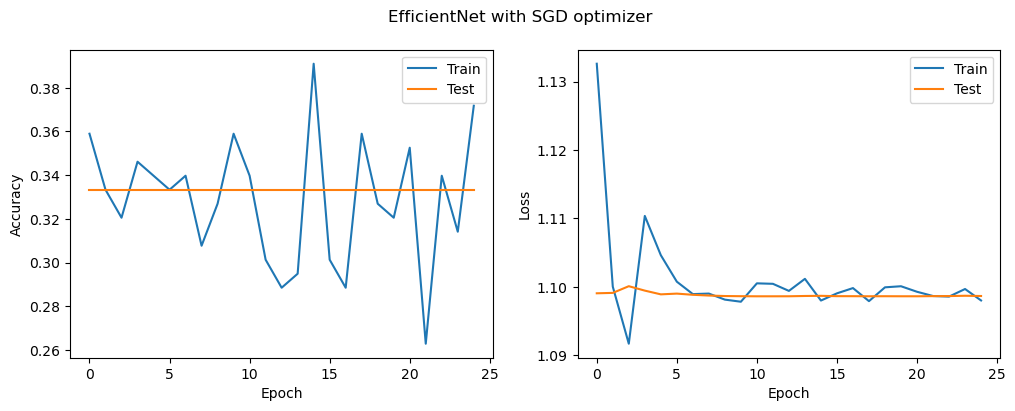

Training EfficientNet with Adam optimizer
Epoch 1/25
5/5 [==============================] - 27s 3s/step - loss: 1.2548 - accuracy: 0.2756 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/25
5/5 [==============================] - 13s 3s/step - loss: 1.1758 - accuracy: 0.3141 - val_loss: 1.1723 - val_accuracy: 0.3333
Epoch 3/25
5/5 [==============================] - 13s 3s/step - loss: 1.1537 - accuracy: 0.3462 - val_loss: 1.0996 - val_accuracy: 0.3333
Epoch 4/25
5/5 [==============================] - 13s 3s/step - loss: 1.0845 - accuracy: 0.3910 - val_loss: 1.1640 - val_accuracy: 0.3333
Epoch 5/25
5/5 [==============================] - 12s 3s/step - loss: 1.1600 - accuracy: 0.3333 - val_loss: 1.0993 - val_accuracy: 0.3333
Epoch 6/25
5/5 [==============================] - 13s 3s/step - loss: 1.1237 - accuracy: 0.2628 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 7/25
5/5 [==============================] - 13s 3s/step - loss: 1.1008 - accuracy: 0.3590 - val_loss: 1.0993 - val_accuracy:

In [ ]:

optimizers = {
    'SGD': lambda: SGD(learning_rate=ExponentialDecay(initial_learning_rate=0.01, decay_steps=100000, decay_rate=1e-6),
                       momentum=0.9, nesterov=True, clipnorm=1.0),
    'Adam': lambda: Adam(learning_rate=0.001, clipnorm=1.0),
}
models = {'EfficientNet': 'efficientnet'}

tensorboard_logs = 'C:\\tensorboard_logs_new'
if not os.path.exists(tensorboard_logs):
    os.makedirs(tensorboard_logs)

for opt_name, opt_func in optimizers.items():
    for model_name, model_type in models.items():
        if model_name == 'CNN' and opt_name == 'SGD':
            continue

        log_dir = os.path.join(tensorboard_logs, f'{model_name}_{opt_name}')
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        print(f'Training {model_name} with {opt_name} optimizer')

        opt = opt_func()

        if model_name == 'CNN':
            model = cnn_model
            model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

            opt.build(model.trainable_variables)
        else:
            model = create_model(model_type, opt)

        history = model.fit(train_generator, epochs=25, validation_data=test_generator, callbacks=[tensorboard_callback])

        plot_history(model_name, opt_name, history)